In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
from matplotlib.ticker import FixedLocator, FuncFormatter, NullLocator
import math
import matplotlib.transforms as mtransforms

fig_dir = './figs/'
os.makedirs(fig_dir, exist_ok=True)

df_all = pd.read_csv('paper-figure_celllist_all.csv')

custom_stack_order = ['Squ.epi', 'Squ.meta', 'Navicular', 'Para.Squ', 'Para.Clust', 'Glan', 'Leu','Debris', 'LSIL', 'HSIL', 'Adenocarcinoma']
legend_stack_order = ['Leu', 'Squ.epi', 'Navicular', 'Para.Squ', 'Squ.meta', 'Glan', 'Para.Clust', 'LSIL', 'HSIL', 'Adenocarcinoma', 'Debris']
legend_labels= ['Leukocyte', 'Superficial/intermediate cell', 'Navicular cell', 'Parabasal cell', 'Squamous metaplasia', 'Glandular cell', 'Miscellaneous cell cluster', 'LSIL', 'HSIL', 'Adenocarcinoma', 'Irrelevant object']

custom_class_order = ['NILM', 'ASC-US', 'LSIL', 'ASC-H', 'HSIL', 'SCC']

facilities = {
    '1_CIH': 'C',
    '2_Tsukuba': 'T',
    '3_Kaetsu': 'K',
    '4_Junten': 'J',
}

FAC_ORDER = ["C","T","K","J"]
HPV_LEVELS = ["-","+"]

APPLY_BH_FOR_PLOTS = False  # 図の星をBH後qで付けたければ True
STAR_THRESHOLDS = [(1e-3,"***"), (1e-2,"**"), (5e-2,"*")]  # p or q の閾値
LINTHRESH = {"LSIL": 100, "HSIL": 1000}  # hybird lin–log のしきい値

probability_threshold = 0.8
for param in custom_stack_order:
    df_all[param] = df_all[f'class_count-{probability_threshold}'].apply(ast.literal_eval).apply(lambda x: x.get(param, 0))

print('----- Check data contents -----')
for facility in facilities.keys():
    df_facility = df_all.query(f'Facility == "{facility}"')
    print(f'Facility: {facility} | Total cases: {len(df_facility)}')

----- Check data contents -----
Facility: 1_CIH | Total cases: 318
Facility: 2_Tsukuba | Total cases: 222
Facility: 3_Kaetsu | Total cases: 385
Facility: 4_Junten | Total cases: 199


Number of samples for HPV violin plot of LSIL: 814


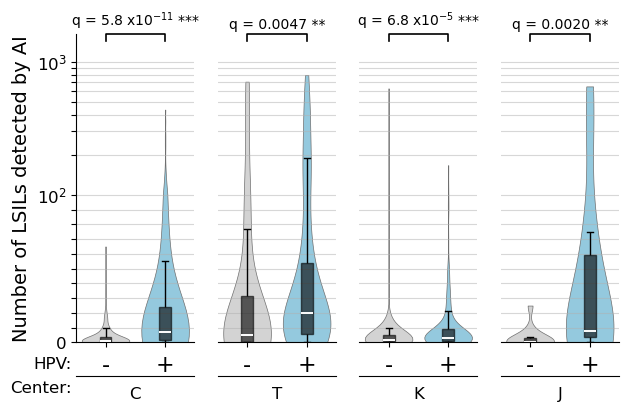

Number of samples for HPV violin plot of HSIL: 814


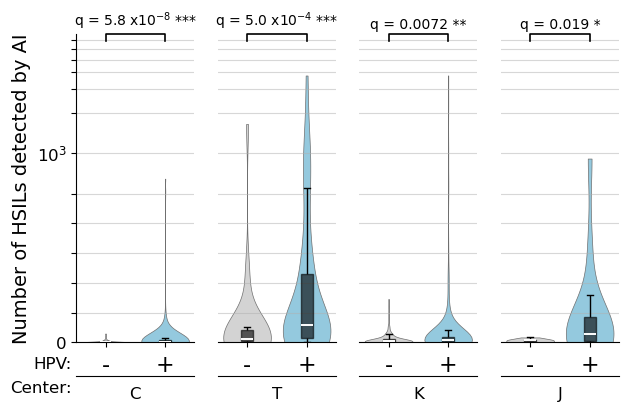

----- HPV Violin plot statistics -----
LSIL:
  subcategory  n_neg  n_pos        U             p             q
0       1_CIH    139    127   4699.0  1.456917e-11  5.827668e-11
1   2_Tsukuba     28    107   1020.0  4.749183e-03  4.749183e-03
2    3_Kaetsu    162    223  13799.5  3.411174e-05  6.822349e-05
3    4_Junten     12     16     32.0  1.463427e-03  1.951236e-03
HSIL:
  subcategory  n_neg  n_pos        U             p             q
0       1_CIH    139    127   5456.0  1.443373e-08  5.773493e-08
1   2_Tsukuba     28    107    856.5  2.513301e-04  5.026602e-04
2    3_Kaetsu    162    223  15320.0  5.375222e-03  7.166962e-03
3    4_Junten     12     16     51.0  1.914099e-02  1.914099e-02


In [2]:
#-----------------------------------------------------------------------------
# Utility functions for plotting symlog Y axis ticks

def auto_linear_step(breakpoint: float, base: int = 10, strict_less: bool = True) -> int:
    if breakpoint <= 1:
        return 1
    k = math.floor(math.log(breakpoint, base))
    step = int(base ** k)
    if strict_less and step >= breakpoint:
        step //= base
    return max(1, step)

def apply_biexp_yticks(ax, breakpoint=1000, base=10, step_linear='auto', log_multipliers=tuple(range(1, 10))):
    if step_linear in (None, 'auto'):
        step_linear = auto_linear_step(breakpoint, base=base, strict_less=True)

    ymin, ymax = ax.get_ylim()
    ymin = max(0, ymin)

    linear_top = min(breakpoint, ymax)
    linear_ticks = np.arange(0, linear_top + step_linear, step_linear)

    log_ticks = []
    if ymax > breakpoint:
        k_start = int(math.ceil(math.log(max(breakpoint, 1e-12), base)))
        k_end = int(math.floor(math.log(max(ymax, 1e-12), base)))
        for k in range(k_start, k_end + 1):
            decade = base ** k
            for m in log_multipliers:
                y = m * decade
                if y > ymax:
                    break
                if y >= max(breakpoint, ymin):
                    log_ticks.append(y)

    ticks = np.unique(np.concatenate([linear_ticks, np.array(log_ticks, dtype=float)]))
    ticks = ticks[(ticks >= ymin) & (ticks <= ymax)]

    def _label_func(y, pos):
        if y == 0:
            return "0"
        if y >= breakpoint:
            k = math.log(y, base)
            # 1×10^k だけにラベル（= 10^k ちょうど）
            if math.isclose(k, round(k), rel_tol=0, abs_tol=1e-9):
                return fr"$10^{int(round(k))}$"
        return ""

    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(_label_func))
    ax.yaxis.set_minor_locator(NullLocator())
    ax.grid(True, axis='y', which='major')


#-----------------------------------------------------------------------------
# Benjamini-Hochberg correction

def _bh_q(p_list):
    p = np.array(p_list, float)
    q = np.full_like(p, np.nan, float)
    mask = ~np.isnan(p); m = mask.sum()
    if m == 0: return q
    idx = np.flatnonzero(mask)
    p_m = p[idx]
    order = np.argsort(p_m, kind="mergesort")
    ranked = p_m[order] * (m / np.arange(1, m+1))
    ranked[::-1] = np.minimum.accumulate(ranked[::-1])
    q[idx[order]] = np.clip(ranked, 0, 1)
    return q



#-----------------------------------------------------------------------------
# Plotting functions


def plot_hpv_violin_with_stats(
    data, 
    yparam, 
    subcategory, 
    subcategory_dict=None, 
    ylabel='Cell count',
    figsize=(8, 4),
    max_val=-1, 
    yscale_type='linear',
    savefilename=''
):

    data = data.query('HPV in ["-", "+"]')
    data = data[data[subcategory].isin(subcategory_dict.keys())].copy()

    print(f'Number of samples for HPV violin plot of {yparam}: {len(data)}')

    category_order = ['-', '+']
    category_palette = {'-': 'lightgray', '+': 'skyblue'}

    if max_val == -1:
        global_top = float(np.nanmax(data[yparam]))
    else:
        global_top = float(max_val)

    ylim_top = global_top * 1.01

    n_sub = len(subcategory_dict)
    if n_sub == 0:
        raise ValueError("Subcategories not found")

    fig, axes = plt.subplots(1, n_sub, figsize=figsize, sharey=True, gridspec_kw={'wspace':0.2})
    if n_sub == 1:
        axes = [axes]

    rows = []

    # Draw plot for each subcategory
    for i, (ax, sub) in enumerate(zip(axes, subcategory_dict.keys())):
        df_f = data.loc[data[subcategory] == sub]

        # Violin plot
        sns.violinplot(
            x='HPV', y=yparam, data=df_f, hue='HPV', 
            order=category_order, palette=category_palette, legend=False,
            inner=None, cut=0, alpha=1, linewidth=0.5, ax=ax
        )

        # Box plot
        sns.boxplot(
            x='HPV', y=yparam, data=df_f,
            order=category_order, showcaps=True, showfliers=False,
            width=0.2, 
            boxprops=dict(facecolor='black', edgecolor='black', linewidth=1, alpha=0.6),
            medianprops=dict(color='white', linewidth=1.4),
            whiskerprops=dict(color='black', linewidth=1.0),
            capprops=dict(color='black', linewidth=1.0),
            ax=ax, zorder=5
        )

        # Statistical test
        group_neg = df_f.loc[df_f['HPV'] == '-', yparam].dropna()
        group_pos = df_f.loc[df_f['HPV'] == '+', yparam].dropna()


        if len(group_neg) > 0 and len(group_pos) > 0:
            stat, pval = mannwhitneyu(group_neg, group_pos, alternative='less')
            rows.append({'subcategory': sub, 'n_neg':len(group_neg), 'n_pos':len(group_pos), 'U':stat, 'p':pval})
        else:
            rows.append({'subcategory': sub, 'n_neg':len(group_neg), 'n_pos':len(group_pos), 'U':np.nan, 'p':np.nan})


        # Axis settings
        ax.set_xlabel(str(subcategory_dict[sub]), fontsize=12, labelpad=7)
        ax.set_ylabel(ylabel, fontsize=14 if ax is axes[0] else 0)
        ax.set_xticks([0, 1], ['-', '+'])
        ax.tick_params(axis='x', labelsize=16, pad=5)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_ylim(top=ylim_top)
        ax.grid(True, axis='y', alpha=0.5)
        if i > 0:
            ax.spines['left'].set_visible(False)
            ax.tick_params(labelleft=False, left=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


        aa = mtransforms.blended_transform_factory(ax.transAxes, ax.transAxes)
        y_baseline = -0.11
        ax.plot([0.00, 1.00], [y_baseline, y_baseline],
                transform=aa, lw=0.8, color='k', clip_on=False)
        if i == 0:
            ax.text(-0.04, -0.07, 'HPV:',    transform=aa, ha='right', va='center', fontsize=12)
            ax.text(-0.04, -0.15, 'Center:', transform=aa, ha='right', va='center', fontsize=12)

        # Y-axis scale setting
        if yscale_type == 'log':
            ax.set_yscale(yscale_type)
            ax.set_ylim(bottom=0, top=ylim_top*2)
        elif 'biexp' in yscale_type:
            _, breakpoint, linscale, base = yscale_type.split('_')  # Ex.) biexp_10_1.0_10
            breakpoint = int(breakpoint)
            linscale = float(linscale)
            base = int(base)
            ax.set_yscale('symlog', linthresh=breakpoint, linscale=linscale, base=base)
            ax.set_ylim(bottom=0, top=ylim_top*2)
            apply_biexp_yticks(ax, breakpoint=breakpoint, base=base)
        else:
            ax.set_yscale('linear')
            ax.set_ylim(bottom=0, top=ylim_top)
            
    p_array = [r['p'] for r in rows]
    q_array = _bh_q(p_array)
    for ax, r, qv in zip(axes, rows, q_array):
        r['q'] = qv

        if np.isnan(qv):
            q_label = 'NA'
        elif qv < 1e-3:
            mantissa, exp = f"{qv:.1e}".split('e')
            exp = int(exp)
            q_label = rf"q = {mantissa} x$10^{{{exp}}}$ ***"
        elif qv < 1e-2:
            q_label = f"q = {qv:.4f} **"
        elif qv < 5e-2:
            q_label = f"q = {qv:.3f} *"
        else:
            q_label = f"q = {qv:.2f}"

        x1, x2 = 0, 1
        y_bar = 1
        xt = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.plot([x1, x1, x2, x2], [y_bar-0.02, y_bar, y_bar, y_bar-0.02], transform=xt, lw=1.2, color='k', clip_on=False)
        ax.text((x1+x2)/2, y_bar+0.01, q_label, transform=xt, ha='center', va='bottom', fontsize=10)


    if savefilename:
        plt.savefig(savefilename, bbox_inches='tight', dpi=300)
    plt.show()

    result_df = pd.DataFrame(rows, columns=['subcategory', 'n_neg', 'n_pos', 'U', 'p', 'q'])
    return result_df


figsize = (7, 4)
stat_LSIL = plot_hpv_violin_with_stats(df_all, 'LSIL', 'Facility', facilities, ylabel='Number of LSILs detected by AI', figsize=figsize, max_val=-1, savefilename=f'{fig_dir}fig7c_LSIL-HPV.svg', yscale_type='biexp_100_1.0_10')
stat_HSIL = plot_hpv_violin_with_stats(df_all, 'HSIL', 'Facility', facilities, ylabel='Number of HSILs detected by AI', figsize=figsize, max_val=-1, savefilename=f'{fig_dir}fig7d_HSIL-HPV.svg', yscale_type='biexp_500_1.0_10')

print('----- HPV Violin plot statistics -----')
print('LSIL:')
print(stat_LSIL)
print('HSIL:')
print(stat_HSIL)
